# Simple decision rules give high accuracy for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [136]:
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.inspection import permutation_importance
from sklearn import tree, ensemble
from sklearn.tree import export_text
from sklearn.metrics import f1_score, recall_score, precision_score

In [122]:
def preprocess(X, drop_cols, one_hot_cols):
    """
    Drop columns listed by drop_cols, turn one_hot_cols into 
    one-hot variables since decision trees must be fitted on numerical data.
    """
    X.drop(columns=drop_cols, inplace=True)
    one_hot = pd.get_dummies(X, columns=one_hot_cols, drop_first=True)
    return one_hot

def fit_and_score(X, y, method=None, depth=3, silent=False):
    """ 
    Fit a decision tree using features X, labels y and maximum depth equal to depth. 
    Print out the ascii tree, accuracy, F1 score and return the model.
    """
    if method is None:
        # Use decision tree
        clf = tree.DecisionTreeClassifier(max_depth=depth)
    else:
        clf = method
    clf = clf.fit(X, y)
    if method is None:
        r = export_text(clf, feature_names=list(X.columns))
        print(r)
    if (not silent):
        print(f"In-sample accuracy:", clf.score(X, y))
        preds = clf.predict(X)
        print(f"In-sample precision score:", precision_score(y, preds))
        print(f"In-sample recall score:", recall_score(y, preds))
        print(f"In-sample F1 score:", f1_score(y, preds))
    return clf
    
def oos_score(model, X, y):
    """
    Print accuracy and F1 score on (possibly) out-of-sample data for model.
    """
    print(f"Out-of-sample accuracy:", model.score(X, y))
    preds = model.predict(X)
    print(f"Out-of-sample F1 score:", f1_score(y, preds))
    
def nonnumeric(df):
    """
    Print out columns that contain NA or have dtype=object.
    """
    print("Columns with NA values:", df.isnull().any()[lambda x: x])
    print("Columns with dtype=object", list(twibot_one_hot.select_dtypes(include='object')))
    print("Columns with dtype=bool", list(twibot_one_hot.select_dtypes(include='bool')))
    
def mdi_feature_importance(clf, labels, ax):
    """
    Plot most important features.
    
    @param clf: fitted classifier
    """
    importances = clf.feature_importances_
    top10 = np.argsort(importances)[-10:] # Get top 10 most important features
    top10 = top10[::-1]
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    mdi_importances = pd.Series(importances, index=labels)
    mdi_importances[top10].plot.bar(yerr=std[top10], ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    return mdi_importances

def permutation_feature_importance(ax, X, y, drop_cols):
    """
    Random forest feature importance on fitted model clf, features. Plot results on ax.
    Warning: computationally expensive, since refits model multiple times.
    """
    processed = preprocess(X, drop_cols, [])
    
    rf = ensemble.RandomForestClassifier(n_estimators=100)
    clf = fit_and_score(X, y, method=rf, silent=True)

    pi = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=1)
    top10 = np.argsort(pi.importances_mean)[-10:] # Get top 10 most important features
    top10 = top10[::-1]
    pi_importances = pd.Series(pi.importances_mean, index=list(X.columns))
    pi_importances[top10].plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")

## "TwiBot-20: A Comprehensive Twitter Bot Detection Benchmark."

Shangbin Feng, Herun Wan, Ningnan Wang, Jundong Li, and Minnan Luo. "TwiBot-20: A Comprehensive Twitter Bot Detection Benchmark." CIKM. 2021.
https://arxiv.org/abs/2106.13088

In [123]:
COLUMNS_TO_DROP = ['id', 
                   'name', 
                   'screen_name', 
                   'url', 
                   'profile_image_url', 
                   'profile_background_image_url_https', 
                   'description',
                   'profile_image_url_https', 
                   'profile_background_image_url', 
                   'profile_text_color', 
                   'profile_sidebar_border_color', 
                   'profile_sidebar_fill_color', 
                   'profile_background_color', 
                   'profile_link_color']
DUMMY_COLUMNS = ['lang', 
                  'time_zone', 
                  'location', 
                  'default_profile', 
                  'default_profile_image', 
                  'utc_offset',
                  'is_translator', 
                  'default_profile', 
                  'default_profile_image', 
                  'profile_background_tile', 
                  'utc_offset',
                  'is_translator', 
                  'protected', 
                  'contributors_enabled', 
                  'geo_enabled',
                  'verified',
                  'profile_use_background_image']

In [139]:
# Load data
def load_twibot(path):
    with open(path) as f:
        twibot = json.load(f)
        twibot_labels = [int(ent['label']) for ent in twibot]
        profs = [ent['profile'] for ent in twibot]
        twibot_df = pd.DataFrame(profs)
    twibot_df["created_at"] = twibot_df["created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y ").timestamp())
    # Turn bool, string columns into ints
    for col in twibot_df:
        if (True in twibot_df):
            twibot_df[col] = twibot_df[col].astype(int)
        if (col in ['followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']):
            twibot_df[col] = twibot_df[col].astype(int)
        if (col in ['is_translation_enabled', 'has_extended_profile']):
            twibot_df[col] = twibot_df[col].astype(bool).astype(int) 
    twibot_one_hot = preprocess(twibot_df, COLUMNS_TO_DROP + ['profile_location', 'entities', 'id_str'], DUMMY_COLUMNS)
    return twibot_df, twibot_one_hot, twibot_labels

twibot_df, twibot_one_hot, twibot_labels = load_twibot("./data/Twibot-20/train.json")

In [144]:
# Fit and score on decision tree
dt_clf = fit_and_score(twibot_one_hot, twibot_labels, depth=1)

|--- verified_True  <= 0.50
|   |--- class: 1
|--- verified_True  >  0.50
|   |--- class: 0

In-sample accuracy: 0.8094950471128292
In-sample precision score: 0.7466645233885227
In-sample recall score: 0.9997847610848042
In-sample F1 score: 0.8548817520934942


In [145]:
# Fit and score on random forest
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf = fit_and_score(twibot_one_hot, twibot_labels, method=rf)

In-sample accuracy: 1.0
In-sample precision score: 1.0
In-sample recall score: 1.0
In-sample F1 score: 1.0


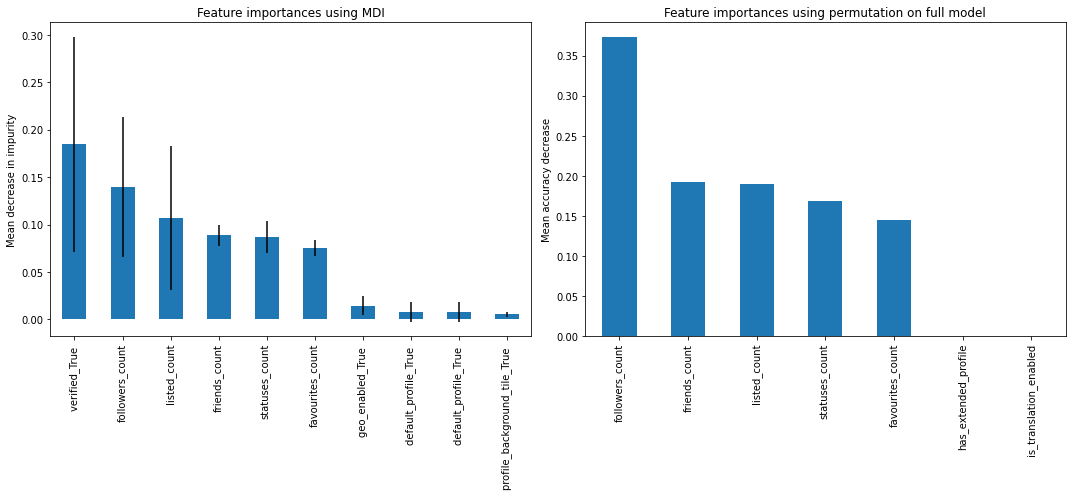

In [146]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
mdi_feature_importance(rf_clf, list(twibot_one_hot.columns), axes[0])
permutation_feature_importance(axes[1], twibot_df, twibot_labels, DUMMY_COLUMNS)
fig.tight_layout()

## botometer-feedback-2019: "Arming the public with artificial intelligence to counter social bots."

Yang, Kai‐Cheng, Onur Varol, Clayton A. Davis, Emilio Ferrara, Alessandro Flammini, and Filippo Menczer. "Arming the public with artificial intelligence to counter social bots." Human Behavior and Emerging Technologies 1, no. 1 (2019): 48-61.

https://arxiv.org/pdf/1901.00912.pdf

Approx. citations: 300

-------------- DECISION TREE --------------
|--- friends_count <= 8.50
|   |--- favourites_count <= 70.00
|   |   |--- time_zone_Atlantic Time (Canada) <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- time_zone_Atlantic Time (Canada) >  0.50
|   |   |   |--- class: 0.0
|   |--- favourites_count >  70.00
|   |   |--- utc_offset_19800.0 <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- utc_offset_19800.0 >  0.50
|   |   |   |--- class: 1.0
|--- friends_count >  8.50
|   |--- friends_count <= 4219.50
|   |   |--- statuses_count <= 143.00
|   |   |   |--- class: 0.0
|   |   |--- statuses_count >  143.00
|   |   |   |--- class: 0.0
|   |--- friends_count >  4219.50
|   |   |--- listed_count <= 41.50
|   |   |   |--- class: 1.0
|   |   |--- listed_count >  41.50
|   |   |   |--- class: 0.0

In-sample accuracy: 0.8111753371868978
In-sample precision score: 0.759493670886076
In-sample recall score: 0.4316546762589928
In-sample F1 score: 0.5504587155963303
-------------- RANDOM FOREST ----------

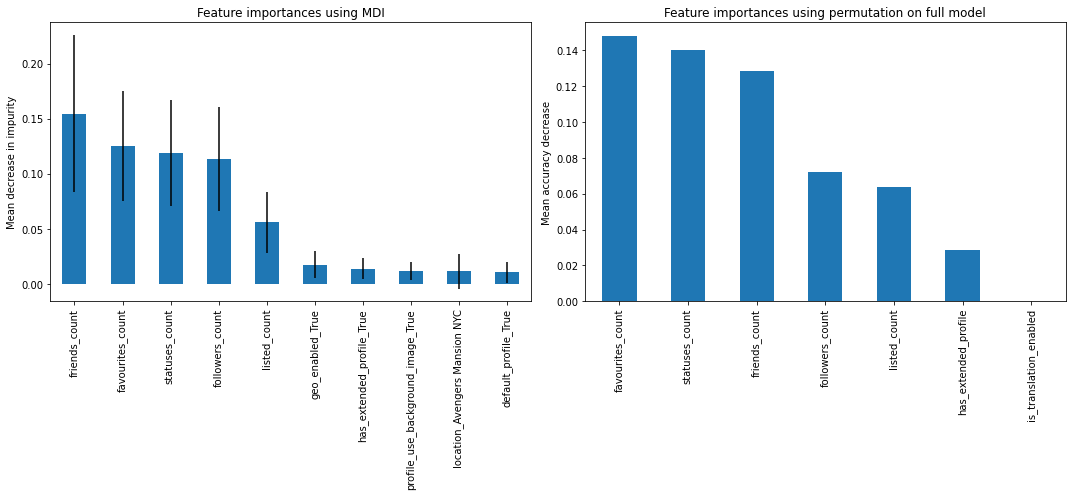

In [149]:
def analyze_bot_repo_dataset(data_path, labels_path, depth=5):
    with open(data_path) as f:
        d = json.load(f)
        profs = [ent['user'] for ent in d]
        df = pd.DataFrame(profs).set_index("id")
        df["created_at"] = df["created_at"].apply(lambda dt: datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp())
    labels = pd.read_csv(labels_path, sep="\t", header=None, names=["id", "label_str"], index_col="id")
    labels.loc[labels['label_str']=="human", 'label'] = 0
    labels.loc[labels['label_str']=="bot", 'label'] = 1
    df, labels = df.align(labels, join="inner", axis=0)
    df.reset_index(inplace=True)
    labels = labels['label']
    one_hot = preprocess(df, COLUMNS_TO_DROP + ['profile_banner_url', 'entities', 'id_str', 'following', 'follow_request_sent', 'notifications', 'translator_type'], DUMMY_COLUMNS + ['is_translation_enabled', 'has_extended_profile'])
    # Fit and score on decision tree
    print("-------------- DECISION TREE --------------")
    dt_clf = fit_and_score(one_hot, labels, depth=depth)
    # Fit and score on random forest
    print("-------------- RANDOM FOREST --------------")
    rf = ensemble.RandomForestClassifier(n_estimators=100)
    rf_clf = fit_and_score(one_hot, labels, method=rf)
    fig, axes = plt.subplots(1,2, figsize=(15,7))
    mdi_feature_importance(rf_clf, list(one_hot.columns), axes[0])
    permutation_feature_importance(axes[1], df, labels, DUMMY_COLUMNS)
    fig.tight_layout()

analyze_bot_repo_dataset("./data/botometer-feedback-2019_tweets.json", "./data/botometer-feedback-2019.tsv", depth=3)


## "Rtbust-2019: Exploiting temporal patterns for botnet detection on twitter."

Mazza, Michele, Stefano Cresci, Marco Avvenuti, Walter Quattrociocchi, and Maurizio Tesconi. "Rtbust: Exploiting temporal patterns for botnet detection on twitter." In Proceedings of the 10th ACM Conference on Web Science, pp. 183-192. 2019.

https://arxiv.org/abs/1902.04506

Approx. citations: 100

-------------- DECISION TREE --------------
|--- favourites_count <= 9206.00
|   |--- friends_count <= 1223.00
|   |   |--- statuses_count <= 2000.50
|   |   |   |--- class: 0.0
|   |   |--- statuses_count >  2000.50
|   |   |   |--- class: 1.0
|   |--- friends_count >  1223.00
|   |   |--- listed_count <= 10.00
|   |   |   |--- class: 0.0
|   |   |--- listed_count >  10.00
|   |   |   |--- class: 0.0
|--- favourites_count >  9206.00
|   |--- favourites_count <= 24401.50
|   |   |--- statuses_count <= 14265.50
|   |   |   |--- class: 0.0
|   |   |--- statuses_count >  14265.50
|   |   |   |--- class: 0.0
|   |--- favourites_count >  24401.50
|   |   |--- favourites_count <= 375503.00
|   |   |   |--- class: 0.0
|   |   |--- favourites_count >  375503.00
|   |   |   |--- class: 1.0

In-sample accuracy: 0.7171717171717171
In-sample precision score: 0.7343283582089553
In-sample recall score: 0.6968838526912181
In-sample F1 score: 0.7151162790697675
-------------- RANDOM FOREST -----------

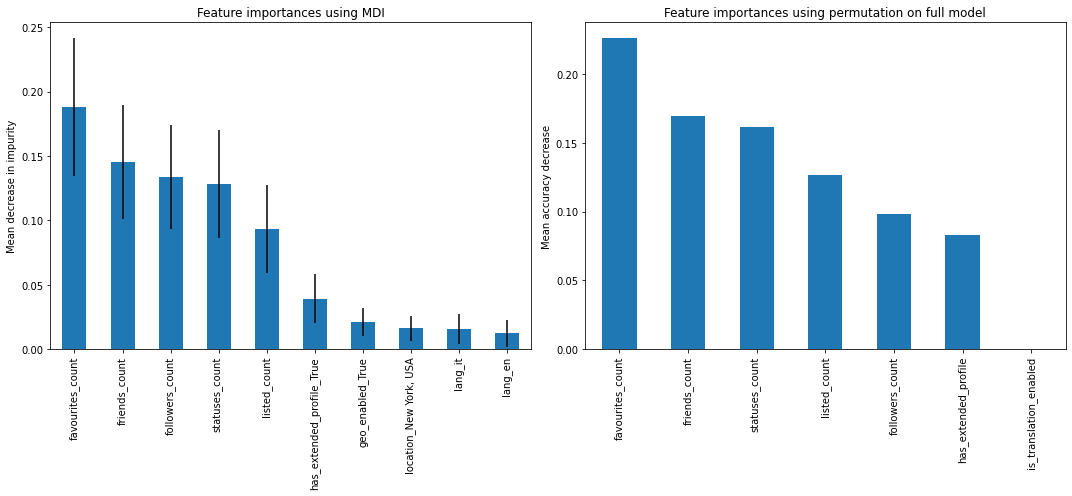

In [150]:
analyze_bot_repo_dataset("./data/cresci-rtbust-2019_tweets.json", "./data/cresci-rtbust-2019.tsv", depth=3)

## cresci-2017: "The paradigm-shift of social spambots: Evidence, theories, and tools for the arms race."

Cresci, S., Di Pietro, R., Petrocchi, M., Spognardi, A., & Tesconi, M. (2017, April). The paradigm-shift of social spambots: Evidence, theories, and tools for the arms race. In Proceedings of the 26th International Conference on World Wide Web Companion (pp. 963-972). ACM.

https://arxiv.org/abs/1701.03017

Approx. citations: 328

In [155]:
# Load in data
folder_names = ['fake_followers', 
 'genuine_accounts', 
 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
is_bot = [1, 0, 1, 1, 1, 1, 1, 1, 1]
dfs = []
cresci_labels = []
for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(f"./data/datasets_full.csv/{name}.csv/users.csv")
    dfs.append(df)
    cresci_labels.extend([ib]*len(df))

    
def format_time(dt):
    try:
        datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp()
    except:
        print(dt)
    
cresci2017 = pd.concat(dfs)


# Preprocess
cresci2017_one_hot = preprocess(cresci2017, 
                        COLUMNS_TO_DROP + ['profile_banner_url', 
                                                        'test_set_1', 
                                                        'test_set_2', 
                                                        'crawled_at',
                                                        'updated', 
                                                        'timestamp',
                                                        'following', 
                                                        'follow_request_sent',
                                                        'created_at'
                                                  ], 
                        DUMMY_COLUMNS + ['notifications',])

# Fit and score decision tree
fit_and_score(cresci2017_one_hot, cresci_labels, depth=1)

|--- favourites_count <= 16.50
|   |--- class: 1
|--- favourites_count >  16.50
|   |--- class: 0

In-sample accuracy: 0.9766146993318485
In-sample precision score: 0.9829826166514181
In-sample recall score: 0.9862309528180649
In-sample F1 score: 0.9846041055718475


DecisionTreeClassifier(max_depth=1)

In [156]:
# Fit and score on random forest
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf = fit_and_score(cresci2017_one_hot, cresci_labels, method=rf)

In-sample accuracy: 1.0
In-sample precision score: 1.0
In-sample recall score: 1.0
In-sample F1 score: 1.0


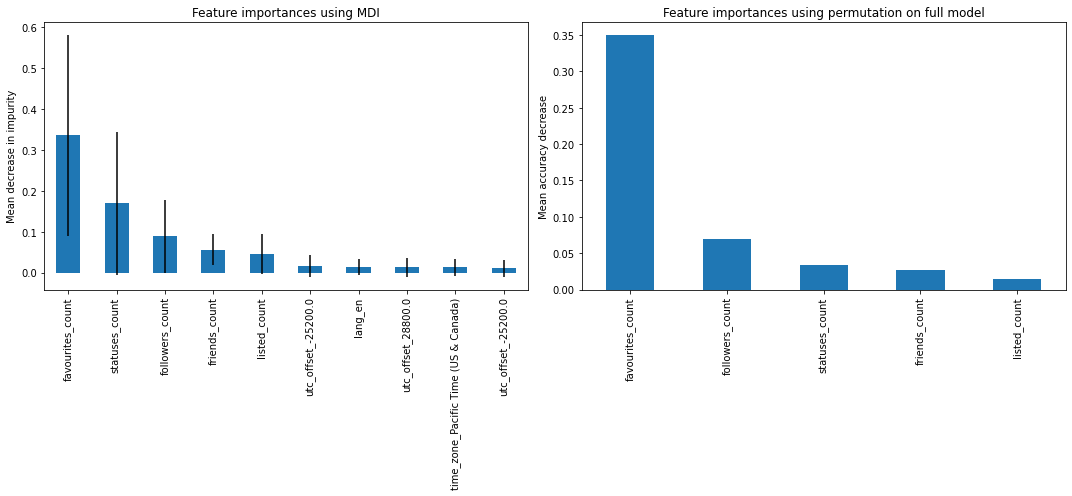

In [157]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
mdi = mdi_feature_importance(rf_clf, list(cresci2017_one_hot.columns), axes[0])
permutation_feature_importance(axes[1], cresci2017, cresci_labels, DUMMY_COLUMNS + ['notifications',])
fig.tight_layout()

## caverlee-2011: "A Long-Term Study of Content Polluters on Twitter."

Lee, Kyumin, Brian David Eoff, and James Caverlee. "A Long-Term Study of Content Polluters on Twitter." ICWSM. 2011.

https://ojs.aaai.org/index.php/ICWSM/article/view/14106

Approx. citations: 500

In [159]:
caverlee2011_bots = pd.read_csv("./data/social_honeypot_icwsm_2011/content_polluters.txt", sep="\t", header=None, names=["UserID", "CreatedAt", "CollectedAt", "NumerOfFollowings", "NumberOfFollowers", "NumberOfTweets", "LengthOfScreenName", "LengthOfDescriptionInUserProfile"])
caverlee2011_humans = pd.read_csv("./data/social_honeypot_icwsm_2011/legitimate_users.txt", sep="\t", header=None, names=["UserID", "CreatedAt", "CollectedAt", "NumerOfFollowings", "NumberOfFollowers", "NumberOfTweets", "LengthOfScreenName", "LengthOfDescriptionInUserProfile"])
caverlee2011 = pd.concat([caverlee2011_bots, caverlee2011_humans])
caverlee2011["CreatedAt"] = caverlee2011["CreatedAt"].apply(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").timestamp())
caverlee2011_labels = [1]*len(caverlee2011_bots) + [0]*len(caverlee2011_humans)


In [162]:
fit_and_score(caverlee2011, caverlee2011_labels, depth=2)

|--- CreatedAt <= 1259512448.00
|   |--- NumerOfFollowings <= 502.50
|   |   |--- class: 0
|   |--- NumerOfFollowings >  502.50
|   |   |--- class: 1
|--- CreatedAt >  1259512448.00
|   |--- class: 1

In-sample accuracy: 0.9061664136485217
In-sample precision score: 0.9098796905049421
In-sample recall score: 0.9154479593214238
In-sample F1 score: 0.9126553317482392


DecisionTreeClassifier(max_depth=2)

In [163]:
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10)
rf_clf = fit_and_score(caverlee2011, caverlee2011_labels, method=rf, depth=2)

In-sample accuracy: 0.9528422371623413
In-sample precision score: 0.9543131276901005
In-sample recall score: 0.9577914772982946
In-sample F1 score: 0.9560491387248187


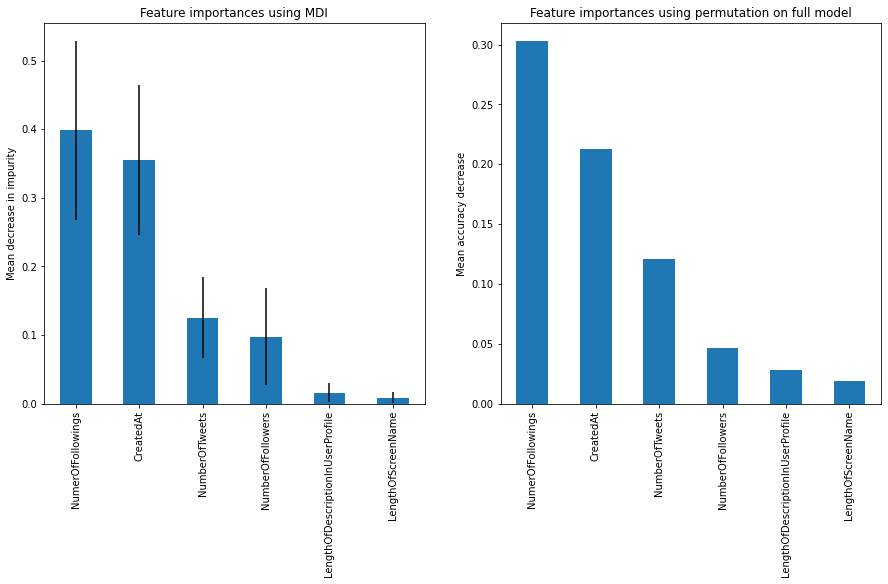

In [164]:
fig, axes =plt.subplots(1, 2, figsize=(15,7))
mdi_feature_importance(rf_clf, list(caverlee2011.columns), axes[0])
permutation_feature_importance(axes[1], caverlee2011, caverlee2011_labels, [])